# Solution of Differential Algebraic Equations with Manifold Constraints on the Latent Space of an Autoencoder
## Alejandro Francisco Queiruga

# Introduction

Consider a general differential algebraic equation of the form
\begin{equation}
z(\dot{u},u) = 0
\end{equation}
We are interested in equations that have the form
\begin{align}
\frac{\mathrm{d}u}{\mathrm{d}t} & = v \\
0 & = c(u,v)
\end{align}
Where do such equations arise? A simple example is the pendulum,
\begin{align}
\text{Solve for}\, x(t), \, y(t), \, f(t) \, \text{satisfying:} \\
m \dot{x} & = f x/L \\
m \dot{y} & = f y/L + m g \\
x^2 + y^2 & = L^2
\end{align}
There are many ways to solve this cannonical equation: Lagrange multipliers (the way we have written it now), penalties, change of variables, etc. The change of variables method is to introduce a new variable $\theta$ that parameterizes $x=L\cos\theta$ and $y=L\sin\theta$:
\begin{align}
\text{Solve for}\, \theta(t) \text{and} \, f(t) \, \text{satisfying:} \\
m \dot{x(\theta)} & = f x(\theta)/L \\
m \dot{y(\theta)} & = f y(\theta)/L + m g \\
\end{align}

In this example, this lets us collapse the problem into a single-component Ordinary Differential Equation. 

Can we automatically discover this parameterization?
(For a such a simple equation, we do not think the proposed methodology will be better, but the pendulum will instead be our *unit test*.)
Our proposed method is motivated by the problems of multiphase reaction and transport, where the underlying constraints are the ill-behaved material properties which are difficult to describe. We change our perspective on these problems in the next section.

## Equations of State

The equations
\begin{align}
\partial_t \rho & = \nabla \cdot \mathbf{k}\nabla p + r\\
\partial_t \rho e & = \nabla \cdot \mathbf{k'}\nabla T + s
\end{align}
The typical methodology is to use the empirical relations for density and enthalpy $h$ as a function of pressure and temperature and solve the DAE for $p$ and $T$ implicitly: 
\begin{align}
\text{Solve for}\, p(t)\, \text{and}\, T(t)\, \text{such that:}\\
\partial_t \rho(p,T) & = \nabla \cdot \mathbf{k}\nabla p + r\\
\partial_t \rho e(p,T) & = \nabla \cdot \mathbf{k'}\nabla T + s
\end{align}
The complicatation is that the functions $\rho(p,T)$ and $u(p,T)$ are not well defined functions due to the presence of phase changes that yield sharp discontinuities in $p,T$, as shown in Figure 1 for water. The material can exist on this section of the surface as a mixture of the two phases.


\begin{figure}

\caption{Density of \chem{H2O} as a function}
\end{figure}

Let us take a step back and look at the problem differentally

\begin{align}
\text{Solve for}\, \rho(t), \, e(t), \, p(t),\, \text{and}\, T(t)\, \text{satisfying:}\\
\partial_t \rho(p,T) & = \nabla \cdot \mathbf{k}\nabla p + r\\
\partial_t \rho e(p,T) & = \nabla \cdot \mathbf{k'}\nabla T + s\\
\text{such that they lie on the material EOS,}\\
EOS(\rho,e,p,T) & = 0
\end{align}

Further, the relations that are used are not the *ground truth* in of themselves. There is no theoretically derived function $EOS(\rho,e,p,T)$ in the general case beyond ideal gases. They are simply complicated fits that were obtained from experimental data. When we look at the corpus of literature on a material as water, what we actually have is a decision branch to multiple different complicated fits for each material branch. The *ground truth* is the experimental data in the first place; the branching curve fit is one instance of representing the data.

The central idea of this work is to obtain two new variables solve for those directly,
\begin{align}
\text{Solve for}\, u(t)\, \text{and}\, v(t)\, \text{such that:}\\
\partial_t \rho(u,v) & = \nabla \cdot \mathbf{k} \nabla p(u,v) + r \\
\partial_t \rho e(u,v) & = \nabla \cdot \mathbf{k'}\nabla T(u,v) + s
\end{align}
where $u$ and $v$ have no physical meaning other than simply being a parameterization of the equation of state constraint. We want to select $u$ and $v$ to require no auxilary phase index to define the system and no additional logic in the code. The sharp kinks and possible discontinuities can be a part of the functions $\rho(u,v), p(u,v), e(u,v)$ and $T(u,v)$.

## Latent Space

Instead of the painstaking work of parameterizing phase boundaries and determining curve fits by hand, we rephrase the problem of representing the equation of state by learning and autoencoder. We have an encoding phase, $E(\rho,p,e,T; a)$ and a decoding phase, $D(u,v; b)$ that forms an identity function with a compressed subspace:
\begin{equation}
\left\{ \rho, p, e, T \right\} \rightarrow  E \rightarrow \left\{ u,v \right\} \rightarrow D \rightarrow \left\{ \rho, p, e, T \right\}
\end{equation}

The autoencoder is solved for by optimizing its parameters using the goal
\begin{equation}
\min_a \sum_x \left( x - D(E(x;a);a) \right)^2
\end{equation}

Note that we are not yet considering constraints $c$ with partial differential equation components in space. These types of material equations of states are only enforced pointwise. The time components of the equations can contain spatial derivatives; i.e. this method fits easily inside a finite volume simulation with little change.

# Methodology


In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pylab as plt
import afqstensorutils as atu

In [2]:
%ls

afqstensorutils.py   paper/          rescale.py~               surf_scaled.csv
afqstensorutils.pyc  pendulum.ipynb  start_jupyter_docker.sh   surf_scaled.csv~
afqstensorutils.py~  proto1.ipynb    start_jupyter_docker.sh~  surf_uv.csv
bound.csv            rescale.py      surf.csv


In [3]:
dataset = tf.contrib.data.CsvDataset(['surf_scaled.csv'],
                                     [tf.float32]*4,
                                     header=True,select_cols=[0,1,2,3])

In [32]:
graph = tf.Graph()
tf.set_random_seed(1234) # Make this notebook deterministic for debugging
with graph.as_default():
    # Input variables of the network
    repeat_dataset = dataset.repeat()
    shuffled_dataset = repeat_dataset.shuffle(buffer_size=100000)
    batched_dataset = shuffled_dataset.batch(2000)
    iterator = batched_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    stacked_stream = tf.stack(next_element)
    tr_x = tf.transpose(stacked_stream)#
    # The parameters
    N_branch = 3
    N_poly = 2
    N_poly_coeff = int(atu.polyexpand(tf.constant([[1,2]]),N_poly).shape[-1])
    p_V, (We1, ad1,bd1, Wd2) = atu.CatVariable([ (4,2), 
                                             (N_poly_coeff,N_branch),
                                             (N_branch,), 
                                             (N_branch,4) ],
                                              stddev=0.1)
    # Encoding phase
    # The latent variable
    def encode(x):
        return tf.matmul( x, We1)
    def decode(u):
        #branches = tf.split(tf.tile(u, [1,N_branch]),num_or_size_splits=N_branch, axis=1)
        #brancha = tf.split(ad1, num_or_size_splits=N_branch, axis=0)
        #polys = [ a*atu.polyexpand(x,N_poly) for a,x in zip(brancha,branches) ]
        multinomial = atu.polyexpand(u,N_poly)
        highordercombos = tf.matmul(multinomial, ad1 )
        #hd1 = tf.nn.relu( highordercombos + bd1 )
        hd1 = highordercombos
        return tf.matmul(hd1,Wd2)

    tr_u = encode(tr_x)
    tr_xd = decode(tr_u)
    
    # The error is how close they are
    goal_auto = tf.reduce_sum(tf.pow(tr_xd - tr_x,2))
    # We also want the latent space to be contractive:
    grad_xd = tf.gradients(tr_xd,tr_u)[0]
    goal_contract = tf.reduce_sum(tf.pow(grad_xd,2))
    goal = goal_auto #+ 0.1*goal_contract
    train_step = tf.train.AdamOptimizer(1e-2).minimize(goal, var_list=[p_V])
    init=tf.global_variables_initializer()
    
    
    i_x = tf.placeholder(tf.float32, shape=(None,4),name='x')
    o_u = encode( i_x )
    # We also want to investigate it
    i_u = tf.placeholder(tf.float32, shape=(None,2),name='u')
    o_xd = decode(i_u)

In [33]:
try:
    sess.close()
except:
    pass
sess = tf.InteractiveSession(graph=graph)

In [34]:
init.run(session=sess)

In [35]:
for i in xrange(1000):
    train_step.run(session=sess)
    if i%100==99:
        print goal.eval(session=sess)

28.214108
22.765553
8.585639
3.5521035
1.6759629
1.1700155
1.7257918
1.2362779
1.2282091
1.8215663


In [36]:
uu,vv = np.meshgrid(np.linspace(-1,1,400), np.linspace(-1,1,400))
uv = np.vstack([uu.ravel(),vv.ravel()])

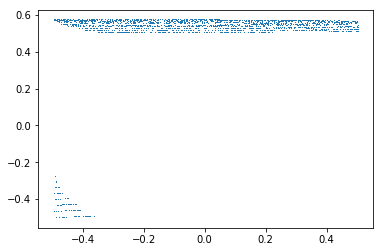

In [37]:
u_en = o_u.eval(feed_dict={i_x:tr_x.eval(session=sess)},session=sess)
xduv = o_xd.eval(feed_dict={i_u:u_en},session=sess)
from matplotlib import pylab as plt
plt.plot(xduv[:,1],xduv[:,2],',')
header="T, p, rho, h"
np.savetxt("surf_uv.csv",xduv,delimiter=", ",header=header,comments="")

In [29]:
We1.eval(session=sess)

array([[ 0.08120275, -0.09895126],
       [-0.08154187, -0.04222417],
       [-0.5249786 ,  0.56564033],
       [ 0.47669283, -0.34868273]], dtype=float32)